<a href="https://colab.research.google.com/github/dondonrocket/kokudo/blob/main/hasegawa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np
import geopandas as gpd
import lightgbm as lgb

from shapely.geometry import Point
from sklearn.model_selection import train_test_split

In [52]:
# =========================
# 1. train / test 読み込み
# =========================

train = pd.read_csv(
    "/content/train.csv",
    encoding="shift_jis",
    encoding_errors="replace",
    low_memory=False
)

test = pd.read_csv(
    "/content/test.csv",
    encoding="shift_jis",
    encoding_errors="replace",
    low_memory=False
)




In [53]:
# =========================
# 2. 駅乗降客数（2019年）
# =========================
df = pd.read_csv("S12-24_NumberOfPassengers_utf8.csv")

df_2019 = df[
    (df["S12_039"] == 1) &  # データ有
    (df["S12_038"] == 1)    # 重複なし
]

station_2019 = (
    df_2019
    .groupby("S12_001c", as_index=False)
    .agg(passengers_2019=("S12_041", "sum"))
    .rename(columns={"S12_001c": "station_code"})
)

In [54]:
# =========================
# 3. 駅ポイント（lon / lat）
# =========================

station_point_gdf = gpd.read_file("/content/S12-24_NumberOfPassengers.geojson")

# 型合わせ（merge対策）
station_point_gdf["S12_001c"] = station_point_gdf["S12_001c"].astype(str)
station_2019["station_code"] = station_2019["station_code"].astype(str)

# 乗降客数と結合
stations = station_point_gdf.merge(
    station_2019,
    left_on="S12_001c",
    right_on="station_code",
    how="left"
)

#先にメートル系へ変換
stations = stations.to_crs(epsg=3857)

# centroid を Point として使う
stations["geometry"] = stations.geometry.centroid

# これで stations は「駅ポイントの GeoDataFrame」
stations_gdf = stations[[
    "S12_001c",
    "passengers_2019",
    "geometry"
]].copy()

stations_gdf.crs = "EPSG:3857"


In [55]:
def add_station_features(df, stations_gdf, radius=500):

    df = df.copy()

    # 物件をGeoDataFrame化
    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["lon"], df["lat"]),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # 空間結合
    joined = gpd.sjoin(
        gdf,
        stations_gdf,
        how="left",
        predicate="dwithin",
        distance=radius
    )


    # 集計
    feat = (
        joined
        .groupby("building_id", as_index=False)
        .agg(
            **{
                f"station_passengers_{radius}m_sum":   ("passengers_2019", "sum"),
                f"station_passengers_{radius}m_max":   ("passengers_2019", "max"),
                f"station_passengers_{radius}m_mean":  ("passengers_2019", "mean"),
            }
        )
    )

    # マージ
    df = df.merge(feat, on="building_id", how="left")

    # 欠損処理 + log
    for col in feat.columns:
        if col != "building_id":
            df[col] = df[col].fillna(0)
            df[col + "_log"] = np.log1p(df[col])

    return df


In [56]:
# =========================
# 5. train / test に付与
# =========================
# 500m
train = add_station_features(train, stations_gdf, radius=500)
test  = add_station_features(test, stations_gdf, radius=500)

# 1000m（追加）
train = add_station_features(train, stations_gdf, radius=1000)
test  = add_station_features(test, stations_gdf, radius=1000)

[c for c in train.columns if "station_passengers" in c]

['station_passengers_500m_sum',
 'station_passengers_500m_max',
 'station_passengers_500m_mean',
 'station_passengers_500m_sum_log',
 'station_passengers_500m_max_log',
 'station_passengers_500m_mean_log',
 'station_passengers_1000m_sum',
 'station_passengers_1000m_max',
 'station_passengers_1000m_mean',
 'station_passengers_1000m_sum_log',
 'station_passengers_1000m_max_log',
 'station_passengers_1000m_mean_log']

In [57]:
# =========================
# 6. 築年 → 築年数
# =========================
for df in [train, test]:
    df["building_create_date"] = pd.to_numeric(
        df["building_create_date"], errors="coerce"
    )
    df["age"] = (2023 - df["building_create_date"]).clip(0, 100)


In [58]:
# =========================
# 7. 学習データ作成
# =========================
y = np.log1p(train["money_room"])

all_data = pd.concat([
    train.drop(columns=["money_room"]),
    test
])

features = all_data.select_dtypes(include=[np.number]).columns.tolist()
features.remove("id")

X = train[features]
X_test = test[features]


In [60]:
# =========================
# 8. LightGBM
# =========================
model = lgb.LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 学習
model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric="mape",
)
#model.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.657264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13568
[LightGBM] [Info] Number of data points in the train set: 291139, number of used features: 96
[LightGBM] [Info] Start training from score 16.872611


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.03, n_estimators=2000,
              num_leaves=64, random_state=42, subsample=0.8)

In [61]:
# =========================
# 可視化（数値で見る）
# =========================
imp = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

imp.head(20)

,feature,importance
14,year_built,7417
49,post1,6383
8,lat,5591
7,lon,5587
50,post2,5570
52,addr1_2,5223
66,house_area,5215
54,el,5060
53,nl,4654
60,snapshot_land_area,4560


<Axes: ylabel='feature'>

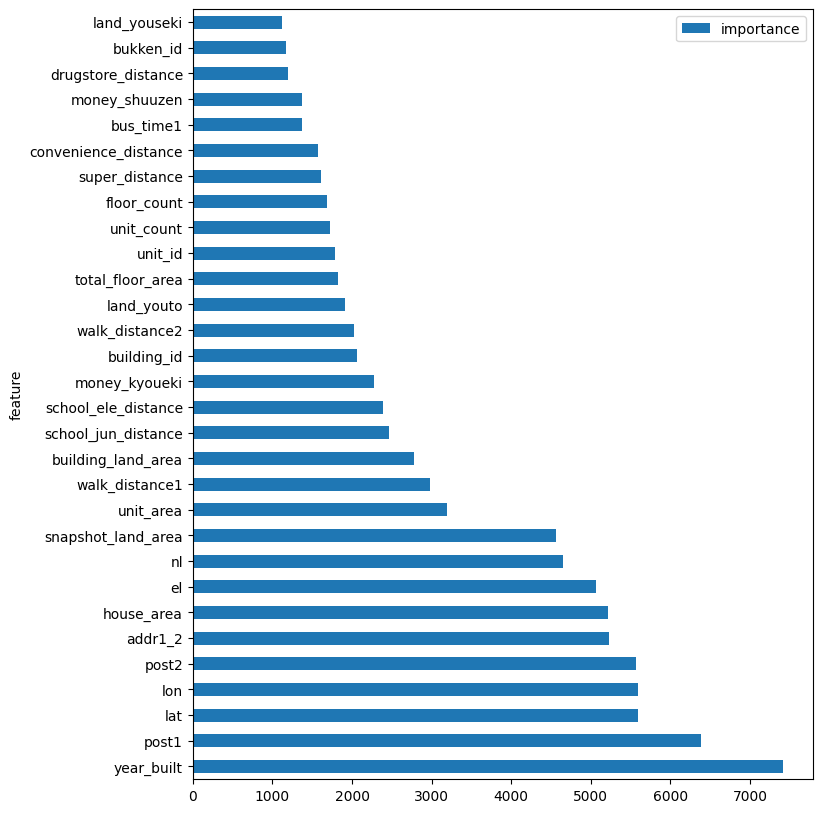

In [62]:
# =========================
# 可視化（グラフで見る）
# =========================
imp.head(30).plot.barh(
    x="feature",
    y="importance",
    figsize=(8, 10)
)


In [63]:
# =========================
# 可視化（上位１０個の特徴量を見る）
# =========================
imp[imp["feature"].str.contains("station_passengers")].head(10)


,feature,importance
104,station_passengers_500m_sum,0
105,station_passengers_500m_max,0
106,station_passengers_500m_mean,0
107,station_passengers_500m_sum_log,0
108,station_passengers_500m_max_log,0
109,station_passengers_500m_mean_log,0
110,station_passengers_1000m_sum,0
111,station_passengers_1000m_max,0
112,station_passengers_1000m_mean,0
113,station_passengers_1000m_sum_log,0


<Axes: ylabel='feature'>

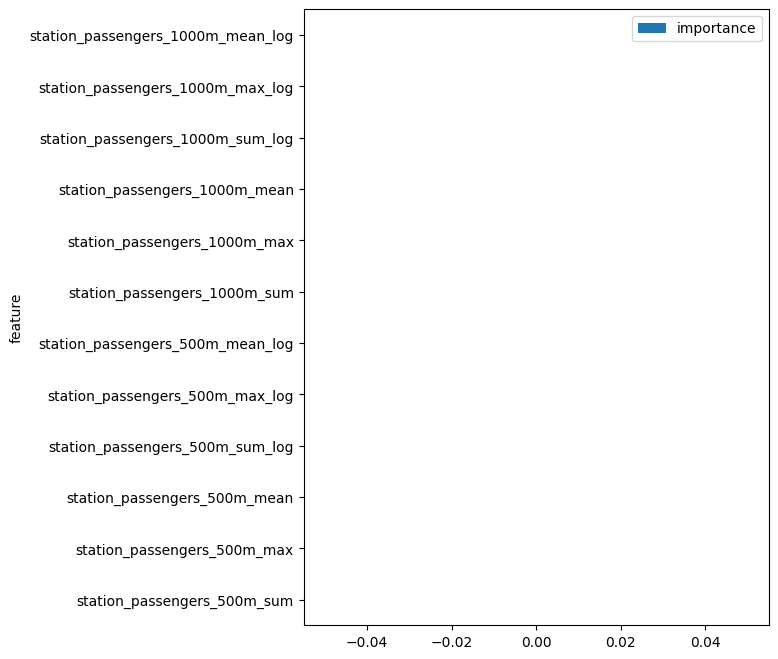

In [64]:
# =========================
# 可視化（５００ｍと１０００ｍの差をみる）
# =========================

imp[imp["feature"].str.contains("station_passengers")].plot.barh(
    x="feature", y="importance", figsize=(6,8)
)


In [65]:
# =========================
# 9. 予測・提出
# =========================
pred = np.expm1(model.predict(X_test))

submit = pd.DataFrame({
    "id": test["id"],
    "money_room": pred
})

submit.to_csv("submit.csv", index=False, header=False)
print("submit.csv を出力しました")



submit.csv を出力しました
